## Multinomial Naive Bayes

In [24]:
!pip install Sastrawi

In [25]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB, GaussianNB
import re
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import warnings
import nltk
from pandas import ExcelWriter
import os
from sklearn import preprocessing
nltk.download('punkt')
warnings.filterwarnings('ignore') 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Read Data

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Training

In [46]:
sheet=["OP","IG","EP","IN","SP"]
temp_teks=[]
temp_label=[]
temp_df=[]
for idx,x in enumerate(sheet):
  temp_teks=(pd.read_excel("/content/drive/MyDrive/SKRIPSI ADIT/training.xlsx",header=None,sheet_name=x))
  temp_label=([x for y in range(len(temp_teks))])
  temp_df.append(pd.DataFrame(temp_teks))
  temp_df[idx].rename(columns={ temp_df[idx].columns[0]: "teks" }, inplace = True)
  temp_df[idx]['label']=temp_label[idx]
data_training=pd.concat(temp_df) 

In [47]:
data_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2876 entries, 0 to 8
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    2876 non-null   object
 1   label   2876 non-null   object
dtypes: object(2)
memory usage: 67.4+ KB


In [48]:
data_training.groupby(['label']).size()

label
EP     402
IG     850
IN      44
OP    1571
SP       9
dtype: int64

In [49]:
data_training.head()

,teks,label
0,"Selamat tahun baru 2019, Sahabat! Hadiah terba...",OP
1,"Halo Sahabat, suka banget ngopi dan ke tempat-...",OP
2,Hai Sahabat! Bagi Sahabat yang belum bisa move...,OP
3,Hai Sahabat! Udah coba promo\nMotoplus? Motopl...,OP
4,Hai Sahabat! karyawan-karyawan Adira Finance m...,OP


### Data Testing

In [50]:
sheet_test=pd.ExcelFile("/content/drive/MyDrive/SKRIPSI ADIT/testing.xlsx").sheet_names
temp_teks=[]
temp_label=[]
temp_df=[]
for idx,x in enumerate(sheet_test):
  temp_teks=(pd.read_excel("/content/drive/MyDrive/SKRIPSI ADIT/testing.xlsx",header=None,sheet_name=x))
  temp_label=([x for y in range(len(temp_teks))])
  temp_df.append(pd.DataFrame(temp_teks))
  temp_df[idx].rename(columns={ temp_df[idx].columns[0]: "teks" }, inplace = True)
  temp_df[idx]['bank']=temp_label[idx]
data_testing=pd.concat(temp_df)

In [51]:
data_testing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    5000 non-null   object
 1   bank    5000 non-null   object
dtypes: object(2)
memory usage: 117.2+ KB


In [52]:
data_testing.head()

,teks,bank
0,"Lagi macet-macetan di jalan, ngobrol sama teme...",Asuransi Tugu
1,Berkendara sambil menelpon itu berbahaya! Kamu...,Asuransi Tugu
2,Waktunya #BeraniLebihBaik dengan install aplik...,Asuransi Tugu
3,Memberikan perlindungan untuk perusahaan tidak...,Asuransi Tugu
4,Yuk #BeraniLebihBaik dengan perlindungan lengk...,Asuransi Tugu


## Preprocessing

### Tokenize

In [58]:
#TRAINING
#
train = list(data_training['teks'].apply(lambda x: x.split(' ')))

#TESTING
#
test = list(data_testing['teks'].apply(lambda x: x.split(' ')))

In [59]:
train[0]

['Selamat',
 'tahun',
 'baru',
 '2019,',
 'Sahabat!',
 'Hadiah',
 'terbaik',
 'untuk',
 'mengawali',
 'tahun',
 'ini',
 'adalah',
 'terciptanya',
 'kebersamaan',
 'yang',
 'Adira',
 'Finance',
 'dan',
 'Sahabat',
 'wujudkan.',
 'Adira',
 'Finance',
 'akan',
 'terus',
 'memberikan',
 'pelayanan',
 'yang',
 'terbaik',
 'dan',
 'semangat',
 'untuk',
 'menciptakan',
 'kebahagiaan\n\n#AdiraFinanceID',
 '#TahunBaru2019',
 'https://t.co/25sfb6MjgD']

In [36]:
test[0][:10]

['Lagi',
 'macet-macetan',
 'di',
 'jalan',
 ',',
 'ngobrol',
 'sama',
 'temen',
 'di',
 'telpon']

### Stopwords Removal

In [60]:
factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

#TRAINING
#
for index, twit in enumerate(train) :
  train[index] = [stopword.remove(kata) for kata in twit]
  
#TESTING
#
for index, twit in enumerate(test) :
  test[index] = [stopword.remove(kata) for kata in twit]

In [38]:
train[0][:10]

['Selamat',
 'tahun',
 'baru',
 '2019',
 ',',
 'Sahabat',
 '!',
 'Hadiah',
 'terbaik',
 '']

In [39]:
test[0][:10]

['Lagi',
 'macet-macetan',
 '',
 'jalan',
 ',',
 'ngobrol',
 'sama',
 'temen',
 '',
 'telpon']

### casefolding

In [61]:
#TRAINING
#
# lowercase
for index, twit in enumerate(train) :
  train[index] = [kata.lower() for kata in twit]

# link
for index, twit in enumerate(train) :
  train[index] = [re.sub("(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)", "", kata) for kata in twit]
for index, twit in enumerate(train) :
  train[index] = [re.sub("([https])\w+", "", kata) for kata in twit]

# hashtag
for index, twit in enumerate(train) :
  train[index] = [re.sub("([#])\w+", "", kata) for kata in twit]

# username
for index, twit in enumerate(train) :
  train[index] = [re.sub("([@])\w+", "", kata) for kata in twit]

# hapus tanda baca
for index, twit in enumerate(train) :
  train[index] = [kata.translate(str.maketrans('','',string.punctuation)) for kata in twit]

# hapus kata kosong
for index, twit in enumerate(train) :
  train[index] = [kata for kata in twit if kata != '']

# hapus link


#TESTING
#
# lowercase
for index, twit in enumerate(test) :
  test[index] = [kata.lower() for kata in twit]

# link
for index, twit in enumerate(test) :
  test[index] = [re.sub("(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)", "", kata) for kata in twit]
for index, twit in enumerate(test) :
  test[index] = [re.sub("([https])\w+", "", kata) for kata in twit]

# hashtag
for index, twit in enumerate(test) :
  test[index] = [re.sub("([#])\w+", "", kata) for kata in twit]

# username
for index, twit in enumerate(test) :
  test[index] = [re.sub("([@])\w+", "", kata) for kata in twit]
                 
# hapus tanda baca
for index, twit in enumerate(test) :
  test[index] = [kata.translate(str.maketrans('','',string.punctuation)) for kata in twit]

# hapus kata kosong
for index, twit in enumerate(test) :
  test[index] = [kata for kata in twit if kata != '']

In [45]:
train[0]

['baru',
 '2019',
 'mengawali',
 'keber',
 'adira',
 'finance',
 'wujudkan',
 'adira',
 'finance',
 'memberikan',
 'menci',
 'keba',
 'adirafinanceid']

In [44]:
test[0][:10]

['lagi',
 'macetmace',
 'jalan',
 'ngobrol',
 'bo',
 'a',
 'cur',
 'kalau',
 'kamu',
 'kebia']

### Stemming

In [ ]:
# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

#TRAINING
#
for index, twit in tqdm(enumerate(train), total=len(train)) :
  train[index] = [stemmer.stem(kata) for kata in twit if kata != '']

#TESTING
#
for index, twit in tqdm(enumerate(test), total=len(test)) :
  test[index] = [stemmer.stem(kata) for kata in twit if kata != '']

In [ ]:
train[0][:10]

In [ ]:
test[0][:10]

## Feature Extraction

### TF - IDF

In [ ]:
#TRAINING
#
train = [' '.join(kata) for kata in train]

#TESTING
#
test = [' '.join(kata) for kata in test]

In [ ]:
# Learn Vocab
#
count_vect = CountVectorizer()
counts_test = count_vect.fit_transform(train + test)

counts = count_vect.transform(train)
counts_test = count_vect.transform(test)

In [ ]:
#TRAINING
#
transformer = TfidfTransformer().fit(counts)
counts = transformer.transform(counts)

#TESTING
#
transformer = TfidfTransformer().fit(counts_test)
counts_test = transformer.transform(counts_test)

In [ ]:
counts

<2876x23399 sparse matrix of type '<class 'numpy.float64'>'
	with 64125 stored elements in Compressed Sparse Row format>

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(data_training['label'])

label = le.transform((data_training['label']))

#test_label = le.transform((data_testing['label']))


### Split dataset 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(counts, label, test_size=(0.3), stratify=label)

### Model

### Classifier

In [ ]:
# multinomial
rng=10000
best=[0,0]

for x in tqdm(range(rng)):
    model = MultinomialNB(alpha=(x/rng)).fit(X_train, y_train)

    if model.score(X_test, y_test)>best[1]:
        best=[(x/rng),model.score(X_test, y_test)]
        
print(best)    

  0%|          | 0/10000 [00:00<?, ?it/s]

[0.0235, 0.8516801853997682]


### Model


In [ ]:
model=MultinomialNB(alpha=best[0]).fit(X_train, y_train)

predicted = model.predict(X_test)
predicted = predicted.tolist()

print(best)
print(np.mean(predicted == y_test))

[0.0235, 0.8516801853997682]
0.8516801853997682


# Evaluation

In [ ]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(predicted)))

              precision    recall  f1-score   support

          EP       0.80      0.82      0.81       121
          IG       0.78      0.78      0.78       255
          IN       0.80      0.31      0.44        13
          OP       0.90      0.92      0.91       471
          SP       0.00      0.00      0.00         3

    accuracy                           0.85       863
   macro avg       0.66      0.57      0.59       863
weighted avg       0.85      0.85      0.85       863



### Labeling Test

In [ ]:
predicted = model.predict(counts_test)

In [ ]:
data_testing['predicted'] = le.inverse_transform(predicted)

In [ ]:
data_testing.head()

,teks,bank,predicted
0,"Lagi macet-macetan di jalan, ngobrol sama teme...",Asuransi Tugu,IG
1,Berkendara sambil menelpon itu berbahaya! Kamu...,Asuransi Tugu,IG
2,Waktunya #BeraniLebihBaik dengan install aplik...,Asuransi Tugu,IG
3,Memberikan perlindungan untuk perusahaan tidak...,Asuransi Tugu,OP
4,Yuk #BeraniLebihBaik dengan perlindungan lengk...,Asuransi Tugu,OP


### Plot

In [ ]:
def get_pct(lst):
  s = sum(lst)
  for x in range(len(lst)):
    lst[x] = lst[x]/s * 100

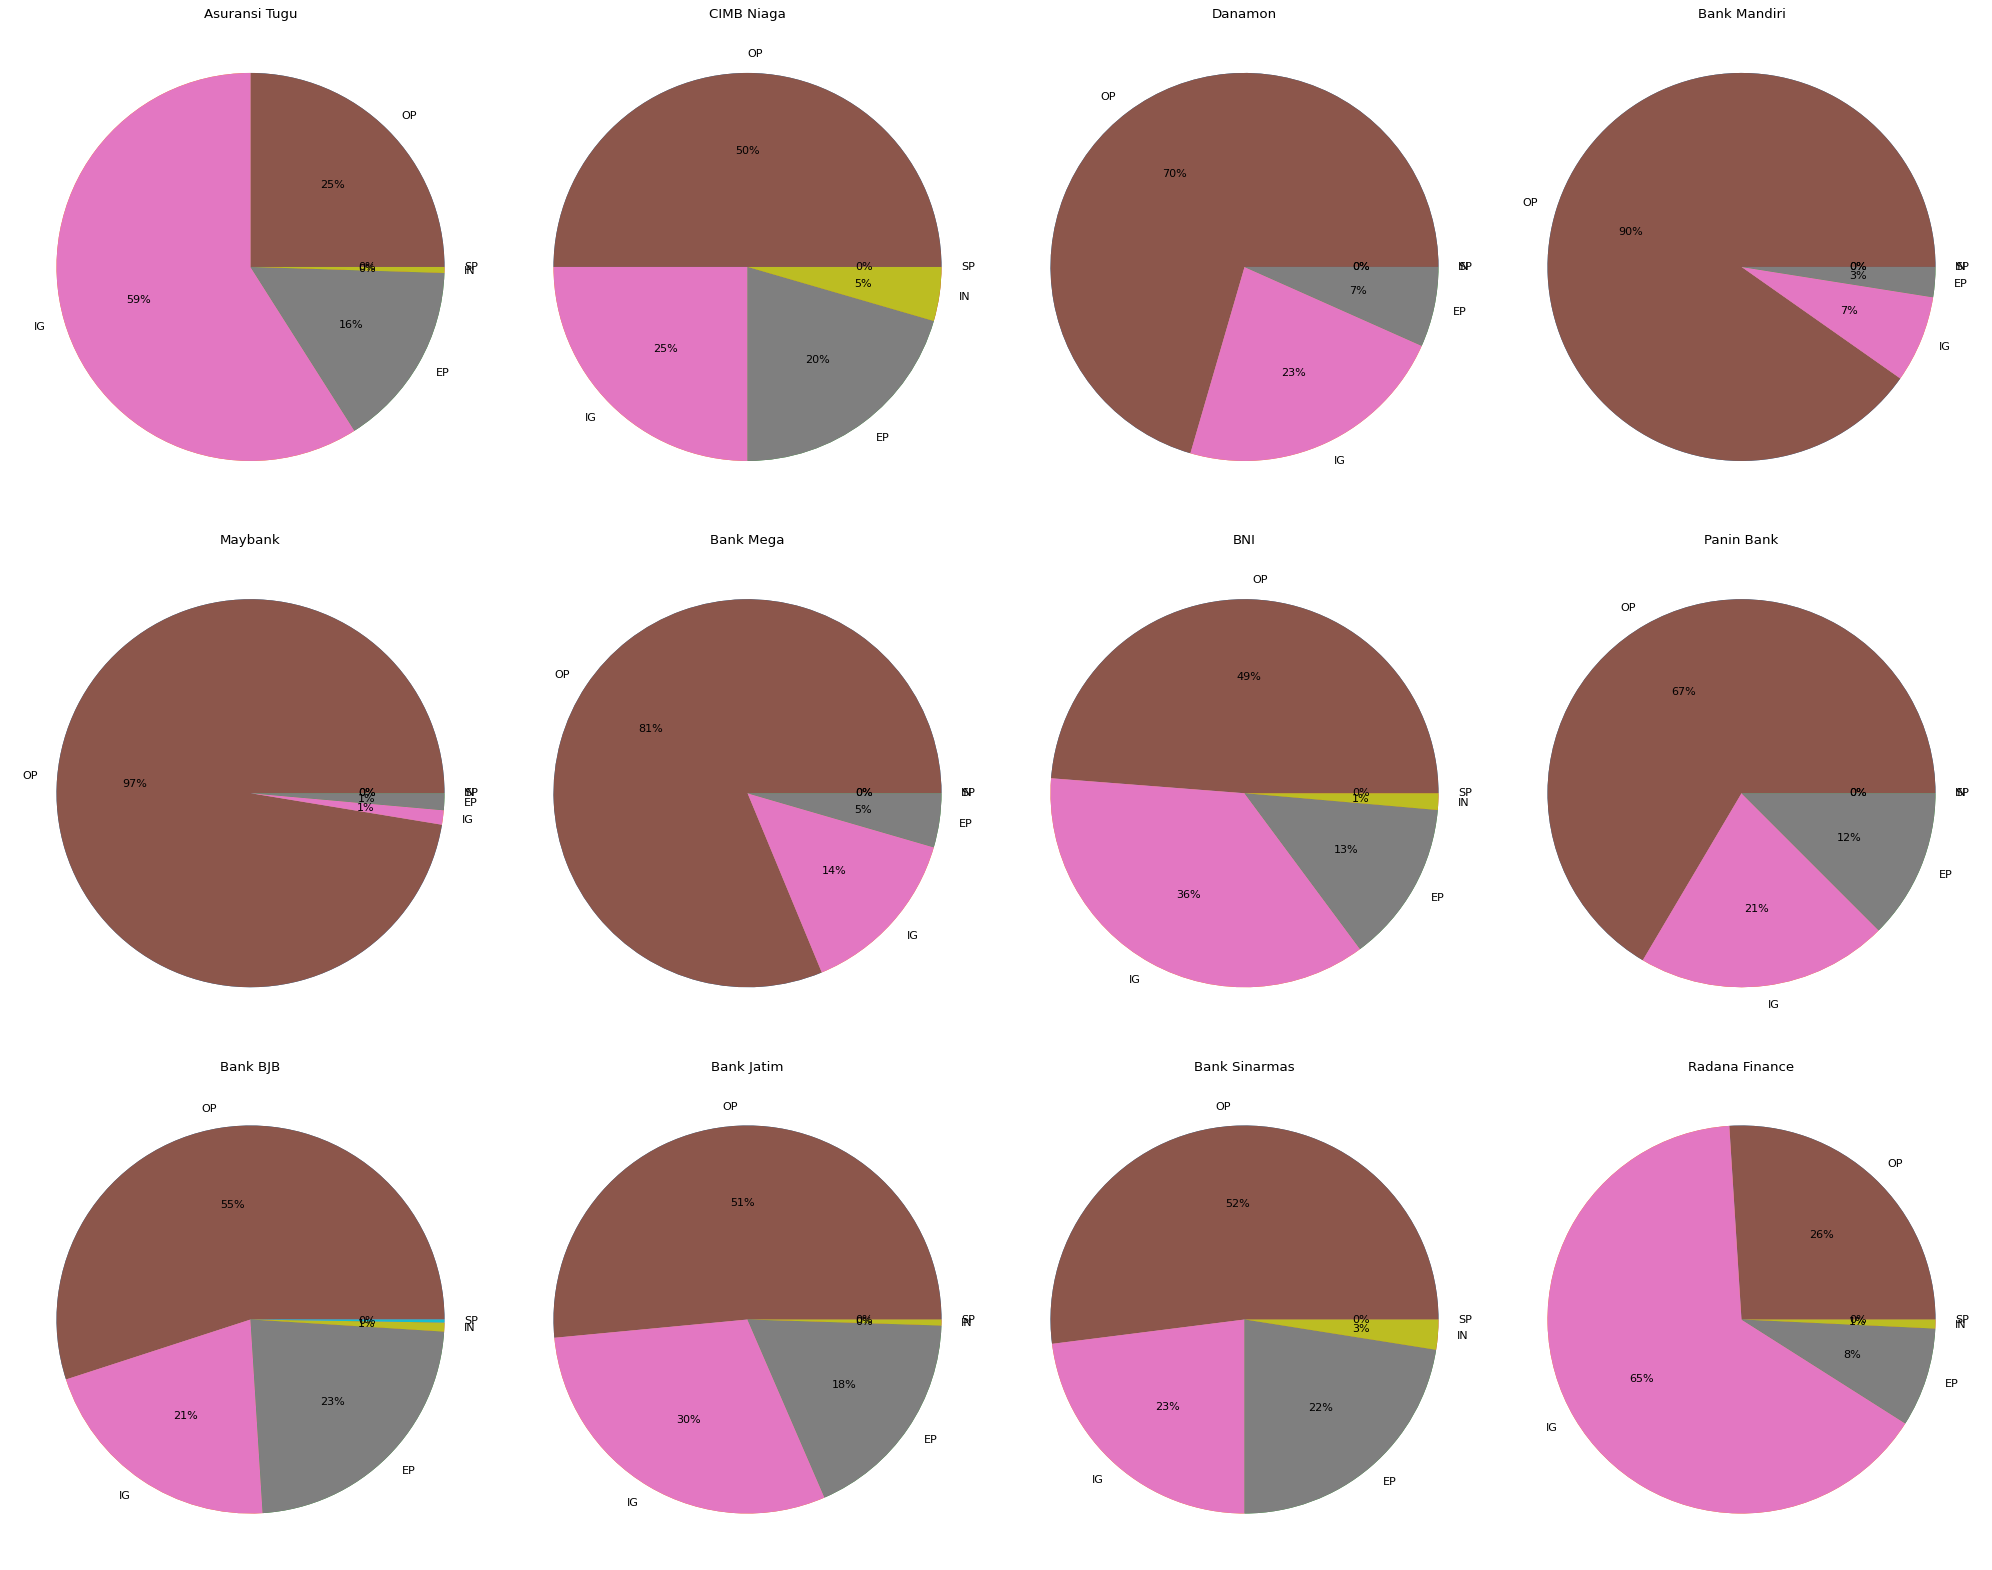

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(25, 20), dpi=80)

for idx, x in enumerate(sheet_test):
  #plt.figure(idx)
  #

  # hitung
  pie_param=[]
  for y in sheet:
    pie_param.append(len(data_testing.loc[(data_testing['bank'] == x) & (data_testing['predicted']==y)]))

  y = np.array(pie_param)
  plt.subplot(3, 4, idx+1)
  plt.title(x)
  plt.pie(y, labels = sheet, autopct='%1.0f%%')
  plt.pie(y)

plt.tight_layout()
#plt.show() #show all figures